# Visualize empirical correlation in HCP data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from readHCP import readHCP
from generateSyntheticData import generateCoordinates
from createBrainMask import createBrainMaskFromb0Data
from preprocessing import replaceNegativeData

%matplotlib inline

C:\Users\sesjojen\AppData\Local\Continuum\Anaconda3\lib\site-packages\skimage\filter\__init__.py:6: skimage_deprecation: The `skimage.filter` module has been renamed to `skimage.filters`.  This placeholder module will be removed in v0.13.
  warn(skimage_deprecation('The `skimage.filter` module has been renamed '


Specify a folder containing preprocessed HCP data.

In [2]:
dataPath = 'C:\\Users\\sesjojen\\Documents\\Data\\HumanConnectomeProject\\mgh_1007\\diff\\preproc'
print(dataPath)

C:\Users\sesjojen\Documents\Data\HumanConnectomeProject\mgh_1007\diff\preproc


Read data from file.

In [3]:
gtab, data, voxelSize = readHCP(dataPath)
print(gtab.info)

B-values shape (552,)
         min 0.000000 
         max 10050.000000 
B-vectors shape (552, 3)
         min -0.998755 
         max 0.998348 
None


This data has some negative values, which is unrealistic. This is taken care of by the function replaceNegativeData().

In [4]:
data = replaceNegativeData(data, gtab)

Convert diffusion encoding to q-space features usable in prediction.

<function matplotlib.pyplot.show>

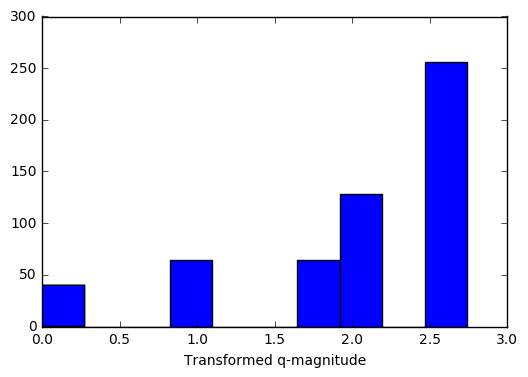

In [110]:
def qMagnitudeTransform(q):
    return np.log(1 + q ** 2) # The constant offset should probably be optimized (issue created)

qvecs = gtab.bvecs
qvals = gtab.qvals[:, np.newaxis]
qvalsTransformed = qMagnitudeTransform(qvals)

qFeatures = np.column_stack((qvalsTransformed, qvecs))

plt.hist(qvalsTransformed)
plt.xlabel('Transformed q-magnitude')
plt.show

Compute the spatial coordinates corresponding to each measurement (this function would be more appropriate somewhere other than in generateSyntheticData -> issue created).

In [6]:
spatialDimensions = data.shape[0:3]
coordinates = generateCoordinates(spatialDimensions, voxelSize)
coordinates.shape

(1881600, 3)

Compute a mask containing the brain. For this we first need to create an average b0-img, which is done by averaging all b0 images. Then, we pass this to createBrainMaskFromb0Data() which uses Dipy's median_otsu() function.


In [7]:
allb0s = data[:, :, :, gtab.b0s_mask]
b0 = np.mean(allb0s, axis=3)

mask = createBrainMaskFromb0Data(b0)

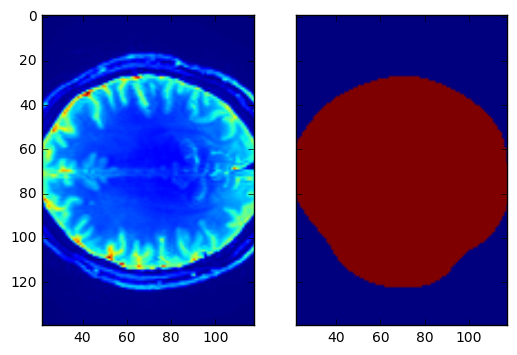

In [8]:
zSlice = 60
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(b0[:, :, zSlice])
ax2.imshow(mask[:, :, zSlice])


Get the (x, y, z)-indices of voxels belonging to the mask using numpy.nonzero().

In [47]:
maskIdx = np.nonzero(mask)
S = data[maskIdx[0], maskIdx[1], maskIdx[2], :]

Normalize by the b0-image, taking advantage of Numpy's broadcasting.

In [48]:
S = S/b0[maskIdx[0], maskIdx[1], maskIdx[2], np.newaxis]
maxSignal = 1.5
percentExceedingMaxSignal = 100*np.sum(S>maxSignal)/np.prod(S.shape)
print('Replacing the top {} % values with {}.'.format(percentExceedingMaxSignal, maxSignal))
S[S > maxSignal] = maxSignal

Replacing the top 0.11240637157867965 % values with 1.5.


Sort columns so that bvals are monotonically increasing: 0, 1000, 3000, 5000, 10000. Adjust other data accordingly.

In [49]:
bvalsIdxIncreasing = np.argsort(gtab.bvals)
bvals = gtab.bvals[bvalsIdxIncreasing]
bvecs = gtab.bvecs[bvalsIdxIncreasing, :]
S = S[:, bvalsIdxIncreasing]
qFeatures = qFeatures[bvalsIdxIncreasing, :]

Some measurements have b = 9950 or b = 10050. We want to treat them as part of the b=10000 shell.

In [50]:
bvals[np.logical_and(bvals >= 9950., bvals <= 10050.)] = 10000. 
shells = np.unique(bvals)
print(shells)
shellIdx = [bvals == b for b in shells]

[     0.   1000.   3000.   5000.  10000.]


From the perspective of the qFeatures, each row in S is an observation and each column is a feature. Assuming that the rows are independent (enough) we can thus estimate the mean  signal as a function of qFeatures by averaging over the rows. The hypothesis is that the mean only depends on the q-magnitude, so we expect the empirical mean to be stepwise constant. 

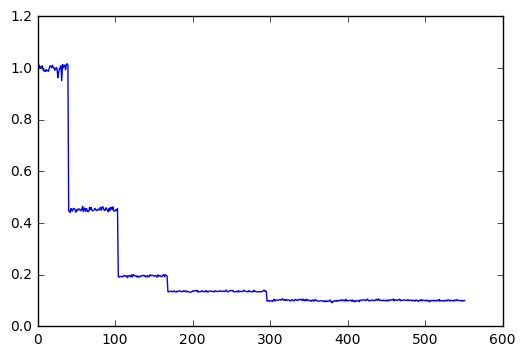

In [51]:
mu = np.mean(S, axis=0)
plt.plot(mu)

The hypothesis seems to hold nicely. Now we can compute the empirical covariance.

In [100]:
def computeEmpiricalCovariance(A):
    mu = np.mean(A, axis=0)
    Acentered = A - mu[np.newaxis, :]
    N = A.shape[0]
    empiricalCovariance = 1/(N-1)*np.dot(Acentered.T, Acentered)
    return empiricalCovariance


def removeShellMeans(A, shellIdx):
    A2 = np.zeros_like(A)
    for ind in shellIdx:
        shellMeans = np.mean(A[:, ind], axis=1)
        A2[:, ind] = A[:, ind] - shellMeans[:, np.newaxis]
    return A2

#R = np.corrcoef(removeShellMeans(S, shellIdx).T)
R = np.corrcoef(S.T)

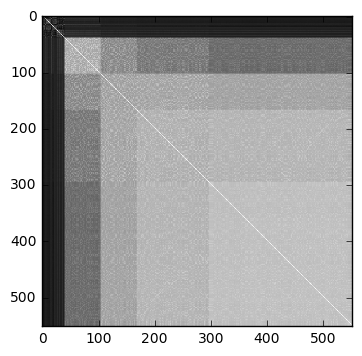

In [101]:
plt.imshow(R, cmap='gray')

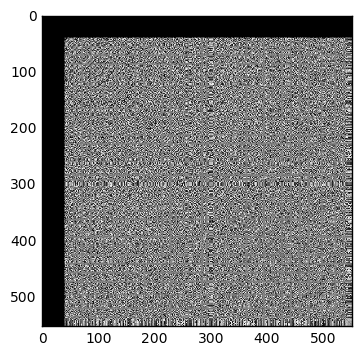

In [111]:
bvecsOuterProd = bvecs.dot(bvecs.T)
bvecsOuterProd[bvecsOuterProd > 1.] = 1.
bvecsOuterProd[bvecsOuterProd < -1.] = -1.
thetaMatrix = np.arccos(bvecsOuterProd)
thetaMatrix[thetaMatrix >= np.pi/2] -= np.pi; 
plt.imshow(thetaMatrix, cmap='gray')

Investigate the covariance as a function of $\theta$ for each shell separately.

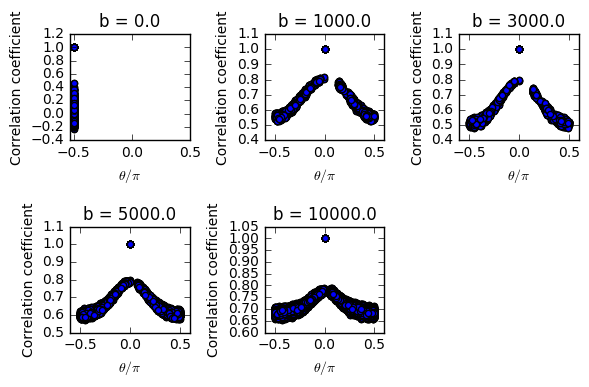

In [115]:
for i in np.arange(len(shells)):
    ind = np.squeeze(np.nonzero(shellIdx[i]))
    subMatrixIdx = np.ix_(ind, ind)
    ax = plt.subplot(2, 3, i+1)
    plt.scatter(thetaMatrix[subMatrixIdx]/np.pi, R[subMatrixIdx])
    plt.xlabel('$\\theta/\pi$')
    plt.ylabel('Correlation coefficient')
    plt.title('b = {}'.format(shells[i]))
    plt.xticks((-0.5, 0, 0.5))
    plt.tight_layout()


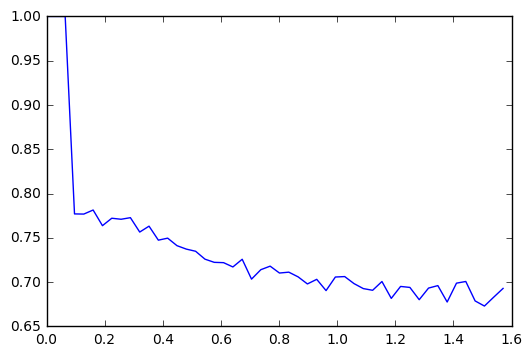

In [68]:
def KNeighborsRegression(x, y, xi):
    from sklearn.neighbors import KNeighborsRegressor
    neigh = KNeighborsRegressor(n_neighbors=5, weights='distance')
    neigh.fit(x, y) 
    yi = neigh.predict(xi)
    plt.plot(xi, yi)
    return yi


def GPregression(x, y, xi):
    from sklearn.gaussian_process import GaussianProcessRegressor
    from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

    kernel = C(0.05) * RBF(0.2)
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

    n = 500
    xTrain = x[:n, :]
    yTrain = y[:n, :]
    gp.fit(xTrain, yTrain)

    yi = gp.predict(xi, return_std=False)
    plt.plot(xi, yi)
    return yi

x = thetaMatrix[subMatrixIdx].flatten()
#x += 1e-3*np.random.randn(len(x)) # Dithering
y = R[subMatrixIdx].flatten()

L = 50
xi = np.linspace(0, np.max(x), L)

x = x[:,np.newaxis]
y = y[:, np.newaxis]
xi = xi[:, np.newaxis]

yi = KNeighborsRegression(x, y, xi)

array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ])